In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import random
import pygame
from loguru import logger
import json
import os

# --- Constants ---
SCREEN_WIDTH = 1200
SCREEN_HEIGHT = 800
FPS = 60

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (220, 50, 50)
GREEN = (50, 220, 50)
BLUE = (50, 50, 220)
GRAY = (150, 150, 150)


In [6]:
import gymnasium as gym
from gymnasium.spaces import Box, Discrete,Tuple
import numpy as np
import pygame

# Define colors
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)  # Color for the trajectory

class CustomEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 60}

    def __init__(self,render_mode=None):
        super().__init__()
        self.grid_size = 10
        self.pause = False
        self.domain_randomization = False
        self.render_mode = render_mode

        # Define two separate thresholds for obstacle handling
        self.distance_threshold_penalty = 5  # Penalty zone threshold (larger value)
        self.distance_threshold_collision = 1.5  # Collision threshold (smaller value)
        self.distance_threshold_arm = 3  # Arm threshold (smaller value)
        self.penalty_factor = 5  # Penalty scaling factor
        self.distance_reward_factor = 2
        self.smooth_action_penalty = 2
        self.steps = 0
        self.margin = 0.3
        self.reward_arm = -100
        self.reward_hand = -100
        self.reward_bound = -200
        self.reward_max_step = 200
        self.reward_step = 10
        self.stride_robot_random = [1,3]
        self.stride_hand_random = [0.6,1]
        self.hand_move_epsilon = 0.1


        self.current_distance = 0  # Current distance to goal, used for reward shaping
        self.max_steps = 50  # Set a maximum number of steps to prevent infinite loops
        # Action space (dx, dy)
        self.action_space = Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        # Observation space (robot_x, robot_y, goal_x, goal_y)
        self.observation_shape = 2+2+2+1+1+1+2+1+1 # Robot position, hand position, velocity_hand,radius_hand, and distance to hand

        self.observation_space = Box(low=0, high=np.array([self.grid_size*2,self.grid_size, self.grid_size*2, self.grid_size,1,1 , (2**0.5)*self.grid_size,0.5*self.grid_size,0.5*self.grid_size,2*self.grid_size,self.grid_size,self.stride_robot_random[1],self.stride_hand_random[1]]), 
                                     shape=(self.observation_shape,), dtype=np.float32)

        self.random = True
        # For rendering
        self.window = None
        self.clock = None
        self.cell_size = 50 # Pixels per grid unit
        self.trajectory_points = [] # New: List to store past robot positions
        self.dist_arm = 0


    def dist_point_to_segment_correct(self,P, A, B, eps=1e-12):
        P = np.asarray(P, dtype=float)
        A = np.asarray(A, dtype=float)
        B = np.asarray(B, dtype=float)
        v = B - A
        w = P - A
        vv = np.dot(v, v)
        if vv <= eps:
            # A and B coincide: treat as point A
            C = A.copy()
            d = np.linalg.norm(P - A)
            t = 0.0
            case = 'endpoint_A'
        else:
            t = np.dot(w, v) / vv
            if t < 0.0:
                C = A
                d = np.linalg.norm(P - A)
                case = 'before_A'
            elif t > 1.0:
                C = B
                d = np.linalg.norm(P - B)
                case = 'after_B'
            else:
                C = A + t * v
                d = np.linalg.norm(P - C)
                case = 'on_segment'
        return float(d), C, float(t), case

    def _get_obs(self):
        
        return np.concatenate(([self.robot_position]+ [self.hand_position]+[self.last_action]+
                               [np.array([self.current_distance])]+
                               [np.array([min(self.robot_position[0],
                                              self.robot_position[1],
                                              self.grid_size-self.robot_position[0],
                                              self.grid_size-self.robot_position[1]) ])]+
                                              [np.array([self.dist_arm])]+
                                               [self.fixed_point]+[np.array([self.stride_robot])]+[np.array([self.stride_hand])]))

    def _get_info(self):
        return {
            "distance_to_hand": self.current_distance,
            "robot_position": self.robot_position,
            "hand_position": self.hand_position,
            'distance_arm':self.dist_arm,
            "fix_point":self.fixed_point,
        }

    def reset(self, seed=None, options=None):

        super().reset()
        self.distance = []
        self.stride_robot = np.random.uniform(*self.stride_robot_random)  # Randomize stride length
        self.stride_hand = np.random.uniform(*self.stride_hand_random)  # Randomize stride length
        # self.stride_robot = 1  # Randomize stride length
        self.distance_threshold_collision = np.random.uniform(2,3)  # Randomize collision threshold
        self.distance_threshold_penalty = np.random.uniform(3, 4)  # Randomize penalty threshold
        
        
        self.noise_obs_sigma = np.random.uniform(0, 0.1)  # Add some noise to observation to make it more realistic
        self.noise_action_sigma = np.random.uniform(0,0.1)  # Add some noise to action to make it more realistic
        
        
        
        self.robot_position = np.random.uniform(self.margin, [2*(self.grid_size-self.margin),self.grid_size-self.margin], size=2)
        self.hand_position = np.random.uniform(self.margin, [2*(self.grid_size-self.margin),self.grid_size-self.margin], size=2)
        # self.hand_position = np.clip(self.hand_position, self.margin, self.grid_size-self.margin)  # Ensure hand stays within grid bounds
        
        # self.hand_move_mode = 'random' if np.random.rand() < 0.1 else 'towards_robot'  # Randomize hand movement mode
        # self.hand_move_mode = 'towards_robot'
        
        self.current_distance = np.linalg.norm(self.robot_position - self.hand_position)
        self.pre_distance = self.current_distance
        self.last_action = np.zeros(2)
        self.steps = 0
        self.trajectory_points = [self.robot_position.copy()] # New: Reset trajectory and add initial position
        
        self.fixed_point = np.array([self.grid_size*random.uniform(0.2,1.8),self.grid_size])
        return self._get_obs(), self._get_info()

    def _reward(self,action):
        terminated = False
        truncated = False
        reward = 0  # Initialize reward
        done_reason = None  # Initialize done reason

        # action regulation penalty
        # reward -= 0.5 * np.sum(np.square(action))  # Penalty for large actions

        self.dist_arm = self.dist_point_to_segment_correct(self.robot_position,self.hand_position, self.fixed_point)[0]
        if self.dist_arm < self.distance_threshold_arm:
            reward += self.reward_arm 
            terminated = True  # Truncate if arm is too short

        # boundary penalty
        if np.any(self.robot_position <= self.margin) or (self.grid_size-self.robot_position[1] <=self.margin) or (2*self.grid_size-self.robot_position[0] <=self.margin):
            reward += self.reward_bound
            terminated = True  # Truncate if robot goes out of bounds
            done_reason = "out of bounds"

    
        # Auxiliary Rewards -  distance to hand
        self.current_distance = np.linalg.norm(self.robot_position - self.hand_position)
        self.distance.append(self.current_distance)
        reward += (self.current_distance-self.pre_distance)*self.distance_reward_factor  # Reward shaping based on distance change
        self.pre_distance = self.current_distance

        # Obstacle handling with two thresholds
        if self.current_distance < self.distance_threshold_collision:
            reward += self.reward_hand
            terminated = True  # Terminate if too close to obstacles
            done_reason = "collision with obstacle"
        elif self.current_distance < self.distance_threshold_penalty:
            reward -= self.penalty_factor * (self.distance_threshold_penalty - self.current_distance)  # Penalty for being too close to obstacles

        reward -= self.smooth_action_penalty * np.linalg.norm(action - self.last_action)

        # Small reward for each step taken to encourage exploration
        reward+= self.reward_step 

        # Truncate if max steps reached and give max step reward
        if self.steps >= self.max_steps:
            reward += self.reward_max_step
            truncated = True  

        return reward,terminated,truncated,done_reason

    def _get_hand_movement(self):

        # if self.hand_move_mode == 'random':
        #     move_hand = np.random.uniform(-1, 1, size=2)  # Randomly move the hand position slightly
        # elif self.hand_move_mode == 'towards_robot':
        #     dir_vector = self.robot_position - self.hand_position
        #     if np.linalg.norm(dir_vector) > 0:
        #         dir_vector /= np.linalg.norm(dir_vector)
        #     move_hand = dir_vector * self.stride_hand  # Move hand towards robot position
        if random.random() < self.hand_move_epsilon:
            move_hand = np.random.uniform(-1, 1, size=2)  # Randomly move the hand position slightly
        else:
            dir_vector = self.robot_position - self.hand_position
            if np.linalg.norm(dir_vector) > 0:
                dir_vector /= np.linalg.norm(dir_vector)
            move_hand = dir_vector * self.stride_hand  # Move hand towards robot position
        
        return move_hand






    def step(self, action):
        if self.random:
            action+=np.random.normal(0,self.noise_action_sigma,size=self.action_space.shape)  # Add some noise to action to make it more realistic

        move_hand = self._get_hand_movement()
        self.hand_position += move_hand  # Update hand position
        self.hand_position = np.clip(self.hand_position, self.margin, [self.grid_size*2,self.grid_size-self.margin])  # Ensure hand stays within grid bounds
        # self.fixed_point+= np.array([np.,0])  # Randomize fixed point position

        self.robot_position += action * self.stride_robot  # Scale the action to control speed
        self.trajectory_points.append(self.robot_position.copy()) # New: Add current position to trajectory
        self.steps += 1
        

        reward,terminated,truncated,done_reason = self._reward(action)
        info = self._get_info()
        info['done_reason'] = done_reason
        info['distance_mean'] = np.mean(self.distance)
        observation = self._get_obs()
        if self.random:
            observation += np.random.normal(0, self.noise_obs_sigma, size=self.observation_shape)  # Add some noise to observation to make it more realistic

        return observation, reward, terminated, truncated, info

    def render(self, mode="human"):
 
        pygame.display.init()
        self.window = pygame.display.set_mode(
                (int(self.grid_size * self.cell_size), int(self.grid_size * self.cell_size))
            )
        pygame.display.set_caption("CustomEnv")
        if self.clock is None:
            self.clock = pygame.time.Clock()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                import sys
                sys.exit() # Exit the program

            elif event.type == pygame.MOUSEBUTTONDOWN:
                mouse_x, mouse_y = event.pos
                self.hand_position = np.array([mouse_x/self.cell_size, mouse_y/self.cell_size])

            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:  # 空格键切换暂停
                    self.pause = not self.pause


        canvas = pygame.Surface((self.grid_size * self.cell_size, self.grid_size * self.cell_size))
        canvas.fill(WHITE)
        virus_image = pygame.image.load("hand.png").convert_alpha()  # Load an image if needed, but not used here
        robot_image = pygame.transform.scale(virus_image, (int(self.cell_size * 2), int(self.cell_size * 2)))  # Scale the image
        # New: Draw the trajectory
        if len(self.trajectory_points) > 1:
            scaled_points = []
            for point in self.trajectory_points:
                scaled_points.append((int(point[0] * self.cell_size), int(point[1] * self.cell_size)))
            
            # Draw lines between consecutive points
            pygame.draw.lines(canvas, BLUE, False, scaled_points, 2) # Blue line, not closed, 2 pixels wide
            
            # Optionally, draw small circles at each point to emphasize
            for point_coord in scaled_points:
                pygame.draw.circle(canvas, BLUE, point_coord, 3) # Small blue circles

        # Draw robot
        pygame.draw.circle(
            canvas,
            RED,
            (int(self.robot_position[0] * self.cell_size), int(self.robot_position[1] * self.cell_size)),
            int(self.cell_size * 0.2)
        )
        # Draw obstacles

        canvas.blit(robot_image, (int((self.hand_position[0]-1) * self.cell_size), int((self.hand_position[1]-1) * self.cell_size+1)))
        pygame.draw.circle(canvas,
                            GREEN, 
                            (int((self.hand_position[0]) * self.cell_size), 
                            int((self.hand_position[1]) * self.cell_size+1)), 
        int(self.cell_size * 0.2)
        )

        self.window.blit(canvas, canvas.get_rect())
        pygame.event.pump()
        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])
        time.sleep(0.5)
    
    def load_args(self, args):
        pass

    def save_args(self,path):
        env_args = {
            "grid_size": self.grid_size,
            "distance_threshold_penalty":self.distance_threshold_penalty,
            "distance_threshold_collision":self.distance_threshold_collision,
            "penalty_factor":self.penalty_factor,
            "distance_reward_factor":self.distance_reward_factor,
            "smooth_action_penalty":self.smooth_action_penalty,
            "max_steps":self.max_steps,
            "margin":self.margin,
            "reward_step":self.reward_step,
            "reward_max_step":self.reward_max_step,
            "reward_bound":self.reward_bound,
            "reward_arm":self.reward_arm,
            "reward_hand":self.reward_hand,
            "stride_robot_range":self.stride_robot_random,
            "stride_hand_range":self.stride_hand_random,
            "move_hand_epsilon":self.hand_move_epsilon,



        }
        with open(os.path.join(path, "env_args.json"), "w") as f:
            json.dump(env_args, f,indent=4)
        

    def close(self):
        pygame.display.quit()
        pygame.quit()





In [4]:
import gymnasium as gym
from gymnasium.spaces import Box, Discrete,Tuple
import numpy as np
import pygame

# Define colors
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)  # Color for the trajectory

class CustomEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 60}

    def __init__(self,render_mode=None):
        super().__init__()
        self.grid_size = 10
        self.pause = False
        self.domain_randomization = False
        self.render_mode = render_mode

        # Define two separate thresholds for obstacle handling
        self.distance_threshold_penalty = 5  # Penalty zone threshold (larger value)
        self.distance_threshold_collision = 1.5  # Collision threshold (smaller value)
        self.distance_threshold_arm = 3  # Arm threshold (smaller value)
        self.penalty_factor = 5  # Penalty scaling factor
        self.distance_reward_factor = 2
        self.smooth_action_penalty = 2
        self.steps = 0
        self.margin = 0.3
        self.reward_arm = -100
        self.reward_hand = -100
        self.reward_bound = -200
        self.reward_max_step = 200
        self.reward_step = 10
        self.stride_robot = 2
        self.stride_hand_random = [0.6,0.8]
        self.hand_move_epsilon = 0.1


        self.current_distance = 0  # Current distance to goal, used for reward shaping
        self.max_steps = 50  # Set a maximum number of steps to prevent infinite loops
        # Action space (dx, dy)
        self.action_space = Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        # Observation space (robot_x, robot_y, goal_x, goal_y)
        self.observation_shape = 2+2+2+1+1+1+2+1  # Robot position, hand position, velocity_hand,radius_hand, and distance to hand
        self.observation_space = Box(low=0, high=np.array([self.grid_size*2,self.grid_size, self.grid_size*2, self.grid_size,1,1 , (2**0.5)*self.grid_size,0.5*self.grid_size,0.5*self.grid_size,2*self.grid_size,self.grid_size]), 
                                     shape=(self.observation_shape,), dtype=np.float32)

        self.random = True
        # For rendering
        self.window = None
        self.clock = None
        self.cell_size = 50 # Pixels per grid unit
        self.trajectory_points = [] # New: List to store past robot positions
        self.dist_arm = 0


    def dist_point_to_segment_correct(self,P, A, B, eps=1e-12):
        P = np.asarray(P, dtype=float)
        A = np.asarray(A, dtype=float)
        B = np.asarray(B, dtype=float)
        v = B - A
        w = P - A
        vv = np.dot(v, v)
        if vv <= eps:
            # A and B coincide: treat as point A
            C = A.copy()
            d = np.linalg.norm(P - A)
            t = 0.0
            case = 'endpoint_A'
        else:
            t = np.dot(w, v) / vv
            if t < 0.0:
                C = A
                d = np.linalg.norm(P - A)
                case = 'before_A'
            elif t > 1.0:
                C = B
                d = np.linalg.norm(P - B)
                case = 'after_B'
            else:
                C = A + t * v
                d = np.linalg.norm(P - C)
                case = 'on_segment'
        return float(d), C, float(t), case

    def _get_obs(self):
        
        return np.concatenate(([self.robot_position]+ [self.hand_position]+[self.last_action]+
                               [np.array([self.current_distance])]+
                               [np.array([min(self.robot_position[0],
                                              self.robot_position[1],
                                              self.grid_size-self.robot_position[0],
                                              self.grid_size-self.robot_position[1]) ])]+
                                              [np.array([self.dist_arm])]+
                                               [self.fixed_point]))

    def _get_info(self):
        return {
            "distance_to_hand": self.current_distance,
            "robot_position": self.robot_position,
            "hand_position": self.hand_position,
            'distance_arm':self.dist_arm,
            "fix_point":self.fixed_point,
        }

    def reset(self, seed=None, options=None):

        super().reset()
        self.distance = []
        self.stride_hand = np.random.uniform(*self.stride_hand_random)  # Randomize stride length
        # self.stride_robot = 1  # Randomize stride length
        self.distance_threshold_collision = np.random.uniform(2,3)  # Randomize collision threshold
        self.distance_threshold_penalty = np.random.uniform(3, 4)  # Randomize penalty threshold
        
        
        self.noise_obs_sigma = np.random.uniform(0, 0.1)  # Add some noise to observation to make it more realistic
        self.noise_action_sigma = np.random.uniform(0,0.1)  # Add some noise to action to make it more realistic
        
        
        
        self.robot_position = np.random.uniform(self.margin, [2*(self.grid_size-self.margin),self.grid_size-self.margin], size=2)
        self.hand_position = np.random.uniform(self.margin, [2*(self.grid_size-self.margin),self.grid_size-self.margin], size=2)
        # self.hand_position = np.clip(self.hand_position, self.margin, self.grid_size-self.margin)  # Ensure hand stays within grid bounds
        
        # self.hand_move_mode = 'random' if np.random.rand() < 0.1 else 'towards_robot'  # Randomize hand movement mode
        # self.hand_move_mode = 'towards_robot'
        
        self.current_distance = np.linalg.norm(self.robot_position - self.hand_position)
        self.pre_distance = self.current_distance
        self.last_action = np.zeros(2)
        self.steps = 0
        self.trajectory_points = [self.robot_position.copy()] # New: Reset trajectory and add initial position
        
        self.fixed_point = np.array([self.grid_size*random.uniform(0.2,1.8),self.grid_size])
        return self._get_obs(), self._get_info()

    def _reward(self,action):
        terminated = False
        truncated = False
        reward = 0  # Initialize reward
        done_reason = None  # Initialize done reason

        # action regulation penalty
        # reward -= 0.5 * np.sum(np.square(action))  # Penalty for large actions

        self.dist_arm = self.dist_point_to_segment_correct(self.robot_position,self.hand_position, self.fixed_point)[0]
        if self.dist_arm < self.distance_threshold_arm:
            reward += self.reward_arm 
            terminated = True  # Truncate if arm is too short

        # boundary penalty
        if np.any(self.robot_position <= self.margin) or (self.grid_size-self.robot_position[1] <=self.margin) or (2*self.grid_size-self.robot_position[0] <=self.margin):
            reward += self.reward_bound
            terminated = True  # Truncate if robot goes out of bounds
            done_reason = "out of bounds"

    
        # Auxiliary Rewards -  distance to hand
        self.current_distance = np.linalg.norm(self.robot_position - self.hand_position)
        self.distance.append(self.current_distance)
        reward += (self.current_distance-self.pre_distance)*self.distance_reward_factor  # Reward shaping based on distance change
        self.pre_distance = self.current_distance

        # Obstacle handling with two thresholds
        if self.current_distance < self.distance_threshold_collision:
            reward += self.reward_hand
            terminated = True  # Terminate if too close to obstacles
            done_reason = "collision with obstacle"
        elif self.current_distance < self.distance_threshold_penalty:
            reward -= self.penalty_factor * (self.distance_threshold_penalty - self.current_distance)  # Penalty for being too close to obstacles

        reward -= self.smooth_action_penalty * np.linalg.norm(action - self.last_action)

        # Small reward for each step taken to encourage exploration
        reward+= self.reward_step 

        # Truncate if max steps reached and give max step reward
        if self.steps >= self.max_steps:
            reward += self.reward_max_step
            truncated = True  

        return reward,terminated,truncated,done_reason

    def _get_hand_movement(self):

        # if self.hand_move_mode == 'random':
        #     move_hand = np.random.uniform(-1, 1, size=2)  # Randomly move the hand position slightly
        # elif self.hand_move_mode == 'towards_robot':
        #     dir_vector = self.robot_position - self.hand_position
        #     if np.linalg.norm(dir_vector) > 0:
        #         dir_vector /= np.linalg.norm(dir_vector)
        #     move_hand = dir_vector * self.stride_hand  # Move hand towards robot position
        if random.random() < self.hand_move_epsilon:
            move_hand = np.random.uniform(-1, 1, size=2)  # Randomly move the hand position slightly
        else:
            dir_vector = self.robot_position - self.hand_position
            if np.linalg.norm(dir_vector) > 0:
                dir_vector /= np.linalg.norm(dir_vector)
            move_hand = dir_vector * self.stride_hand  # Move hand towards robot position
        
        return move_hand






    def step(self, action):
        if self.random:
            action+=np.random.normal(0,self.noise_action_sigma,size=self.action_space.shape)  # Add some noise to action to make it more realistic

        move_hand = self._get_hand_movement()
        self.hand_position += move_hand  # Update hand position
        self.hand_position = np.clip(self.hand_position, self.margin, [self.grid_size*2,self.grid_size-self.margin])  # Ensure hand stays within grid bounds
        # self.fixed_point+= np.array([np.,0])  # Randomize fixed point position

        self.robot_position += action * self.stride_robot  # Scale the action to control speed
        self.trajectory_points.append(self.robot_position.copy()) # New: Add current position to trajectory
        self.steps += 1
        

        reward,terminated,truncated,done_reason = self._reward(action)
        info = self._get_info()
        info['done_reason'] = done_reason
        info['distance_mean'] = np.mean(self.distance)
        observation = self._get_obs()
        if self.random:
            observation += np.random.normal(0, self.noise_obs_sigma, size=self.observation_shape)  # Add some noise to observation to make it more realistic

        return observation, reward, terminated, truncated, info

    def render(self, mode="human"):
 
        pygame.display.init()
        self.window = pygame.display.set_mode(
                (int(self.grid_size * self.cell_size), int(self.grid_size * self.cell_size))
            )
        pygame.display.set_caption("CustomEnv")
        if self.clock is None:
            self.clock = pygame.time.Clock()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                import sys
                sys.exit() # Exit the program

            elif event.type == pygame.MOUSEBUTTONDOWN:
                mouse_x, mouse_y = event.pos
                self.hand_position = np.array([mouse_x/self.cell_size, mouse_y/self.cell_size])

            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:  # 空格键切换暂停
                    self.pause = not self.pause


        canvas = pygame.Surface((self.grid_size * self.cell_size, self.grid_size * self.cell_size))
        canvas.fill(WHITE)
        virus_image = pygame.image.load("hand.png").convert_alpha()  # Load an image if needed, but not used here
        robot_image = pygame.transform.scale(virus_image, (int(self.cell_size * 2), int(self.cell_size * 2)))  # Scale the image
        # New: Draw the trajectory
        if len(self.trajectory_points) > 1:
            scaled_points = []
            for point in self.trajectory_points:
                scaled_points.append((int(point[0] * self.cell_size), int(point[1] * self.cell_size)))
            
            # Draw lines between consecutive points
            pygame.draw.lines(canvas, BLUE, False, scaled_points, 2) # Blue line, not closed, 2 pixels wide
            
            # Optionally, draw small circles at each point to emphasize
            for point_coord in scaled_points:
                pygame.draw.circle(canvas, BLUE, point_coord, 3) # Small blue circles

        # Draw robot
        pygame.draw.circle(
            canvas,
            RED,
            (int(self.robot_position[0] * self.cell_size), int(self.robot_position[1] * self.cell_size)),
            int(self.cell_size * 0.2)
        )
        # Draw obstacles

        canvas.blit(robot_image, (int((self.hand_position[0]-1) * self.cell_size), int((self.hand_position[1]-1) * self.cell_size+1)))
        pygame.draw.circle(canvas,
                            GREEN, 
                            (int((self.hand_position[0]) * self.cell_size), 
                            int((self.hand_position[1]) * self.cell_size+1)), 
        int(self.cell_size * 0.2)
        )

        self.window.blit(canvas, canvas.get_rect())
        pygame.event.pump()
        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])
        time.sleep(0.5)
    
    def load_args(self, args):
        pass

    def save_args(self,path):
        env_args = {
            "grid_size": self.grid_size,
            "distance_threshold_penalty":self.distance_threshold_penalty,
            "distance_threshold_collision":self.distance_threshold_collision,
            "penalty_factor":self.penalty_factor,
            "distance_reward_factor":self.distance_reward_factor,
            "smooth_action_penalty":self.smooth_action_penalty,
            "max_steps":self.max_steps,
            "margin":self.margin,
            "reward_step":self.reward_step,
            "reward_max_step":self.reward_max_step,
            "reward_bound":self.reward_bound,
            "reward_arm":self.reward_arm,
            "reward_hand":self.reward_hand,
            "stride_robot":self.stride_robot,
            "stride_hand_range":self.stride_hand_random,
            "move_hand_epsilon":self.hand_move_epsilon,



        }
        with open(os.path.join(path, "env_args.json"), "w") as f:
            json.dump(env_args, f,indent=4)
        

    def close(self):
        pygame.display.quit()
        pygame.quit()





In [10]:
def render_environment(robot_position, hand_position, fix_point,trajectory_points, grid_size=10, cell_size=50):
    WHITE = (255, 255, 255)
    RED = (255, 0, 0)
    GREEN = (0, 255, 0)
    BLUE = (0, 0, 255)
    pygame.init()
    window = pygame.display.set_mode((grid_size * cell_size*2, grid_size * cell_size))
    canvas = pygame.Surface((grid_size * cell_size*2, grid_size * cell_size))
    canvas.fill(WHITE)
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            import sys
            sys.exit() # Exit the program

        elif event.type == pygame.MOUSEBUTTONDOWN:
            mouse_x, mouse_y = event.pos
            hand_position = np.array([mouse_x/cell_size, mouse_y/cell_size])

    if len(trajectory_points) > 1:
        scaled_points = [(int(point[0] * cell_size), int(point[1] * cell_size)) for point in trajectory_points]
        pygame.draw.lines(canvas, BLUE, False, scaled_points, 2)
        for point_coord in scaled_points:
            pygame.draw.circle(canvas, BLUE, point_coord, 3)

    pygame.draw.lines(canvas, (255, 224, 189), False,[hand_position*cell_size, [fix_point[0]*cell_size,fix_point[1]*cell_size]],width=25)

    virus_image = pygame.image.load("hand.png").convert_alpha()  # Load an image if needed, but not used here
    robot_image = pygame.transform.scale(virus_image, (int(cell_size * 2), int(cell_size * 2)))  # Scale the 
    pygame.draw.circle(canvas, RED, (int(robot_position[0] * cell_size), int(robot_position[1] * cell_size)), int(cell_size * 0.2))
    pygame.draw.circle(canvas, GREEN, (int(hand_position[0] * cell_size), int(hand_position[1] * cell_size)), int(cell_size * 0.2))
    canvas.blit(robot_image, (int((hand_position[0]-1) * cell_size), int((hand_position[1]-1) * cell_size)))
    font = pygame.font.Font(None, 24)
    text = font.render(f"{hand_position[0]},{hand_position[1]}", True, BLUE)
    text_rect = text.get_rect()
    text_rect.center = (int(hand_position[0] * cell_size), int(hand_position[1] * cell_size))
    window.blit(canvas, canvas.get_rect())
    # window.blit(text, text_rect)
    pygame.display.flip()

    return hand_position

In [5]:
from collections import deque
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList
class DebugCallback(BaseCallback):
    def __init__(self, env, render_freq=10000, n_episodes=1, log_freq=10000, verbose=1):
        super().__init__(verbose)
        self.log_freq = log_freq
        # 用deque统计最近N个done的终止原因，避免内存爆炸
        self.termination_reasons = deque(maxlen=1000)  # 统计最近1000次终止
        self.env_to_render = env
        self.render_freq = render_freq
        self.n_episodes = n_episodes
        self.distance_mean = deque(maxlen=1000) 

    def _on_step(self) -> bool:
        # 先从env info里读取终止原因
        # print((self.locals.keys()))
        infos = self.locals.get('infos', None)

        dones = self.locals.get('dones', None)
        if infos is not None and dones is not None:
            for done, info in zip(dones, infos):
                if done and info is not None and 'done_reason' in info:
                    self.termination_reasons.append(info['done_reason'])
                    self.distance_mean.append(info['distance_mean'])

        # 每log_freq步打印信息
        # if self.num_timesteps % self.render_freq == 0 and self.verbose:
        #     for ep in range(self.n_episodes):
        #         obs = self.env_to_render.reset()
        #         done = False
        #         while not done:
        #             action, _states = self.model.predict(obs, deterministic=True)
        #             obs, rewards, done, info = self.env_to_render.step(action)
        #             self.env_to_render.render()
        #             time.sleep(0.6)

        #             if done:

        #                 self.env_to_render.close()
        #                 break





        if self.num_timesteps % self.log_freq == 0 and self.verbose:
            log = self.model.logger.name_to_value
            ep_rew = log.get('rollout/ep_rew_mean', None)
            ep_len = log.get('rollout/ep_len_mean', None)
            loss = log.get('train/loss', None)
            v_loss = log.get('train/value_loss', None)
            p_loss = log.get('train/policy_gradient_loss', None)
            ent_loss = log.get('train/entropy_loss', None)
            kl = log.get('train/approx_kl', None)

            # 统计终止原因比例
            total = len(self.termination_reasons)
            if total > 0:
                count_hand = sum(1 for r in self.termination_reasons if r == 'out of bounds')
                ratio_hand = count_hand / total
            else:
                ratio_hand = 0.0
            distance_mean = sum(self.distance_mean) / len(self.distance_mean) if len(self.distance_mean) > 0 else 0.0

            # print(f"[{self.num_timesteps:7d}] ep_rew_mean={ep_rew}, ep_len_mean={ep_len}, loss={loss:.3f}, "
            #       f"v_loss={v_loss:.3f}, p_loss={p_loss:.3f}, ent_loss={ent_loss:.3f}, kl={kl:.4f}, "
            #       f"termination_reason_hand_ratio={ratio_hand:.3f}")
            self.logger.record("custom/termination_reason_ratio", ratio_hand)

            self.logger.record("custom/distance_mean", distance_mean)
            self.logger.dump(step=self.num_timesteps)

        return True


In [6]:
from matplotlib import pyplot as plt

def metric(trajectory):
    
    distance = [x[6] for x in trajectory]

    # distance_distribution 
    plt.hist(distance, bins=10, density=True,edgecolor='black', alpha=0.7,color='skyblue')
    plt.xlabel('distance')
    plt.ylabel('density')
    plt.title('distance distribution')
    plt.pause(0.1)



In [67]:
import gymnasium as gym
import torch
from stable_baselines3 import PPO,SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecMonitor
from stable_baselines3.common.monitor import Monitor

env_raw = CustomEnv()
save_path = "logs/best_model_sac"
i=1
while os.path.exists(save_path+str(i)):
    i+=1
save_path = f"{save_path}{i}"
os.makedirs(save_path)

tensorboard_dir = "./sac_custom_env_tensorboard"
os.makedirs(tensorboard_dir, exist_ok=True)
tensorboard_log_dir = tensorboard_dir + '/'+ f'best_model_sac{i}'
load_model = "logs/best_model_sac44/best_model.zip"





env =DummyVecEnv([lambda: Monitor(env_raw)])  # Wrap the environment with Monitor for logging

# env = VecNormalize(env, norm_obs=True, norm_reward=True)
policy_kwargs = dict(
    net_arch=[dict(pi=[128,256,256,128], qf=[128,256,256,128])],
    # activation_fn=torch.nn.ReLU  # 改为 ReLU，通常更适合稀疏奖励
)
policy_kwargs = dict(
    net_arch=[128,256,256,128],
    # activation_fn=torch.nn.ReLU  # 改为 ReLU，通常更适合稀疏奖励
)
# model = PPO("MlpPolicy", env, verbose=1,policy_kwargs=policy_kwargs,tensorboard_log="./ppo_custom_env_tensorboard/")
# model = PPO.load("logs/best_model4/best_model.zip",env=env)  # Load the best model
# model.learning_rate = 0.0008
# model.ent_coef = 0.02  # Set a lower learning rate for fine-tuning


model = SAC("MlpPolicy", env, verbose=1,ent_coef='auto',policy_kwargs=policy_kwargs,tensorboard_log=tensorboard_log_dir)

# model = SAC.load(load_model, env, verbose=1,ent_coef='auto',learning_rate=0.0001,tensorboard_log=tensorboard_log_dir)


eval_callback = EvalCallback(
    env,
    best_model_save_path=save_path,
    log_path = './logs/',
    eval_freq=10000,  # 每1000步评估一次
    deterministic=True,
    render=True,
    n_eval_episodes=10,  # 每次评估5个episode
)



debug_callback = DebugCallback(env=env,log_freq=10000, verbose=1)
callback = CallbackList([eval_callback, debug_callback])



model.learn(total_timesteps=400000,callback=callback)
# env.save("vec_env.pkl")  # Save the environment state

settings = {
    'load_model':load_model,
    'tensorboard_log' :tensorboard_log_dir,
           }
env_raw.save_args(save_path)
with open(os.path.join(save_path, "settings.json"), "w") as f:
    json.dump(settings, f)

env.close()

Using cpu device
Logging to ./sac_custom_env_tensorboard/best_model_sac59\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.25     |
|    ep_rew_mean     | -215     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 833      |
|    time_elapsed    | 0        |
|    total_timesteps | 5        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.5      |
|    ep_rew_mean     | -160     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2297     |
|    time_elapsed    | 0        |
|    total_timesteps | 28       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.75     |
|    ep_rew_mean     | -162     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 2172     |
| 

g:\anaconda\envs\RL\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.83     |
|    ep_rew_mean     | -157     |
| time/              |          |
|    episodes        | 40       |
|    fps             | 491      |
|    time_elapsed    | 0        |
|    total_timesteps | 113      |
| train/             |          |
|    actor_loss      | 1.65     |
|    critic_loss     | 1.21e+04 |
|    ent_coef        | 0.997    |
|    ent_coef_loss   | -0.0111  |
|    learning_rate   | 0.0003   |
|    n_updates       | 12       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.8      |
|    ep_rew_mean     | -155     |
| time/              |          |
|    episodes        | 44       |
|    fps             | 325      |
|    time_elapsed    | 0        |
|    total_timesteps | 123      |
| train/             |          |
|    actor_loss      | 8.6      |
|    critic_loss     | 1.27e+04 |
|    ent_coef 

g:\anaconda\envs\RL\lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:259: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.8     |
|    ep_rew_mean     | -31.7    |
| time/              |          |
|    episodes        | 1016     |
|    fps             | 43       |
|    time_elapsed    | 231      |
|    total_timesteps | 10062    |
| train/             |          |
|    actor_loss      | 55.3     |
|    critic_loss     | 287      |
|    ent_coef        | 0.383    |
|    ent_coef_loss   | 0.0405   |
|    learning_rate   | 0.0003   |
|    n_updates       | 9961     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.8     |
|    ep_rew_mean     | -30.2    |
| time/              |          |
|    episodes        | 1020     |
|    fps             | 43       |
|    time_elapsed    | 233      |
|    total_timesteps | 10124    |
| train/             |          |
|    actor_loss      | 63.8     |
|    critic_loss     | 268      |
|    ent_coef 

In [23]:
from stable_baselines3 import SAC,PPO
# env =DummyVecEnv([lambda: Monitor(CustomEnv())])  # Wrap the environment with Monitor for logging

# env = VecNormalize.load('vec_norm.pkl',env)
# env = VecNormalize(env)  # Apply normalization to the environment
# seed = np.random.randint(0,1000)
# from custom_env import CustomEnv
env = CustomEnv()
env.random = False


model= SAC.load("logs/best_model_sac59/best_model.zip",env=env)  # Load the best model

obs,_ = env.reset()
env.stride_hand = 1
env.stride_robot = 1.2
state_history = []
max_steps = 40000

for i in range(max_steps):
    obs = env._get_obs()
    info = env._get_info()

    action, _states = model.predict(obs, deterministic=True)
    obs, reward, teminated,_, info = env.step(action)
    state_history.append(obs)
    # print(f"obs:{obs}")
    # print(f"action:{action}")



    # print(info["robot_position"],info["hand_position"])
    # print("Reward:", reward)
    # print("distance_arm:",info['distance_arm'])
    # env.render()
    env.hand_position = render_environment(info["robot_position"], info["hand_position"],info["fix_point"], trajectory_points=env.trajectory_points)
    time.sleep(0.6)  # Control the frame rate
    if teminated:
        env.hand_position = render_environment(info["robot_position"], info["hand_position"],info["fix_point"], trajectory_points=env.trajectory_points)
        time.sleep(0.6)
        env.close()
        break
        print("Resetting environment")
metric(state_history)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


NameError: name 'metric' is not defined

In [16]:
env = CustomEnv()
print(env.__dict__.keys())
env.stride_hand = 1
print(env.__dict__.keys())

dict_keys(['grid_size', 'pause', 'domain_randomization', 'render_mode', 'distance_threshold_penalty', 'distance_threshold_collision', 'distance_threshold_arm', 'penalty_factor', 'distance_reward_factor', 'smooth_action_penalty', 'steps', 'margin', 'reward_arm', 'reward_hand', 'reward_bound', 'reward_max_step', 'reward_step', 'stride_robot_random', 'stride_hand_random', 'hand_move_epsilon', 'current_distance', 'max_steps', 'action_space', 'observation_shape', 'observation_space', 'random', 'window', 'clock', 'cell_size', 'trajectory_points', 'dist_arm'])
dict_keys(['grid_size', 'pause', 'domain_randomization', 'render_mode', 'distance_threshold_penalty', 'distance_threshold_collision', 'distance_threshold_arm', 'penalty_factor', 'distance_reward_factor', 'smooth_action_penalty', 'steps', 'margin', 'reward_arm', 'reward_hand', 'reward_bound', 'reward_max_step', 'reward_step', 'stride_robot_random', 'stride_hand_random', 'hand_move_epsilon', 'current_distance', 'max_steps', 'action_space'

In [18]:
model.nn = 1

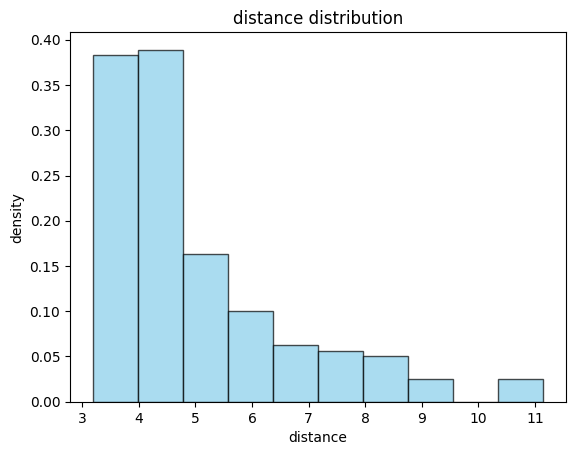

In [80]:
metric(state_history)